# Annual Hindcast Predictions

In this example, we evaluate hindcasts (retrospective forecasts) of sea surface temperatures in the eastern equatorial Pacific from CESM-DPLE. These hindcasts are evaluated against a forced ocean--sea ice simulation that initializes the model.

See the [quick start](https://climpred.readthedocs.io/en/latest/quick-start.html) for an analysis of time series (rather than maps) from a hindcast prediction ensemble.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import climpred
from climpred.tutorial import load_dataset
from climpred import HindcastEnsemble
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import warnings
warnings.filterwarnings("ignore")

We'll load in a small region of the eastern equatorial Pacific for this analysis example.

In [2]:
load_dataset()

'MPI-control-1D': decadal prediction ensemble area averages of SST/SSS/AMO.
'MPI-control-3D': decadal prediction ensemble lat/lon/time of SST/SSS/AMO.
'MPI-PM-DP-1D': area averages for the control run of SST/SSS.
'MPI-PM-DP-3D': lat/lon/time for the control run of SST/SSS.
'CESM-DP-SST': decadal prediction ensemble of global mean SSTs.
'CESM-DP-SSS': decadal prediction ensemble of global mean SSS.
'CESM-DP-SST-3D': decadal prediction ensemble of eastern Pacific SSTs.
'CESM-LE': uninitialized ensemble of global mean SSTs.
'MPIESM_miklip_baseline1-hind-SST-global': initialized ensemble of global mean SSTs
'MPIESM_miklip_baseline1-hist-SST-global': uninitialized ensemble of global mean SSTs
'MPIESM_miklip_baseline1-assim-SST-global': assimilation in MPI-ESM of global mean SSTs
'ERSST': observations of global mean SSTs.
'FOSI-SST': reconstruction of global mean SSTs.
'FOSI-SSS': reconstruction of global mean SSS.
'FOSI-SST-3D': reconstruction of eastern Pacific SSTs


In [3]:
hind = load_dataset('CESM-DP-SST-3D')['SST']
recon = load_dataset('FOSI-SST-3D')['SST']
print(hind)

<xarray.DataArray 'SST' (init: 64, lead: 10, nlat: 37, nlon: 26)>
[615680 values with dtype=float32]
Coordinates:
    TLAT     (nlat, nlon) float64 ...
    TLONG    (nlat, nlon) float64 ...
  * init     (init) float32 1954.0 1955.0 1956.0 1957.0 ... 2015.0 2016.0 2017.0
  * lead     (lead) int32 1 2 3 4 5 6 7 8 9 10
    TAREA    (nlat, nlon) float64 ...
Dimensions without coordinates: nlat, nlon


These two example products cover a small portion of the eastern equatorial Pacific.

[Text(0.5, 1.0, 'Example Data Coverage')]

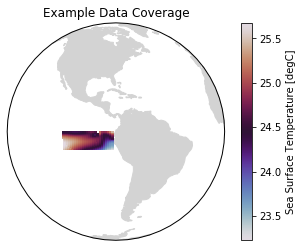

In [4]:
ax = plt.axes(projection=ccrs.Orthographic(-80, 0))
p = ax.pcolormesh(recon.TLONG, recon.TLAT, recon.mean('time'), 
              transform=ccrs.PlateCarree(), cmap='twilight')
ax.add_feature(cfeature.LAND, color='#d3d3d3')
ax.set_global()
plt.colorbar(p, label='Sea Surface Temperature [degC]')
ax.set(title='Example Data Coverage')

We first need to remove the same climatology that was used to drift-correct the CESM-DPLE. Then we'll create a detrended version of our two products to assess detrended predictability.

In [5]:
# Remove 1964-2014 climatology.
recon = recon - recon.sel(time=slice(1964, 2014)).mean('time')

# Remove trend to look at anomalies.
recon = climpred.stats.rm_trend(recon, dim='time')
hind = climpred.stats.rm_trend(hind, dim='init')

Although functions can be called directly in `climpred`, we suggest that you use our classes (`HindcastEnsemble` and `PerfectModelEnsemble`) to make analysis code cleaner.

In [6]:
hindcast = HindcastEnsemble(hind)
hindcast.add_reference(recon, 'reconstruction')
print(hindcast)

<climpred.HindcastEnsemble>
Initialized Ensemble:
    SST      (init, lead, nlat, nlon) float32 -0.29811984 ... 0.5265896
reconstruction:
    SST      (time, nlat, nlon) float32 0.2235269 0.22273289 ... 1.3010706
Uninitialized:
    None


We can now compute the ACC over all leads and all grid cells.

In [7]:
predictability = hindcast.compute_metric(metric='acc')
# `compute_metric` dropped the TLAT coordinate for some reason. This will
# be fixed in a later version of `climpred`.
predictability['TLAT'] = recon['TLAT']
predictability = predictability.set_coords('TLAT')

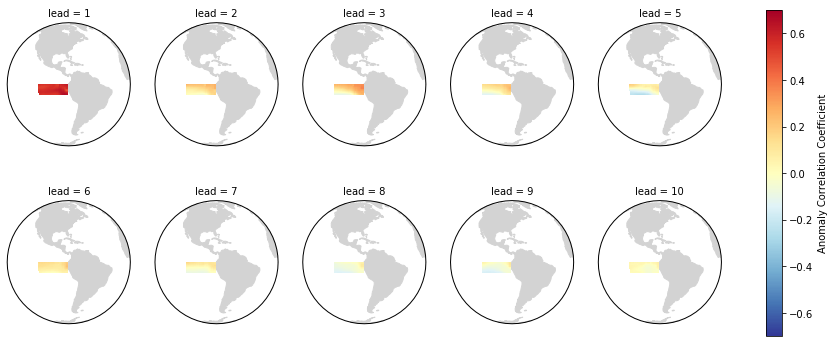

In [8]:
p = predictability.SST.plot.pcolormesh(x='TLONG', y='TLAT', 
                                       transform=ccrs.PlateCarree(), col='lead',
                                       col_wrap=5,
                                       subplot_kws={'projection': ccrs.Orthographic(-80, 0),},
                                       vmin=-0.7, vmax=0.7, cmap='RdYlBu_r',
                                       cbar_kwargs={'label': 'Anomaly Correlation Coefficient'}
                                       )
for ax in p.axes.flat:
    ax.add_feature(cfeature.LAND, color='#d3d3d3', )
    ax.set_global()
    
plt.draw()

We can also check error in our forecasts, just by changing the metric keyword.

In [9]:
rmse = hindcast.compute_metric(metric='rmse')
rmse['TLAT'] = recon['TLAT']
rmse = rmse.set_coords('TLAT')

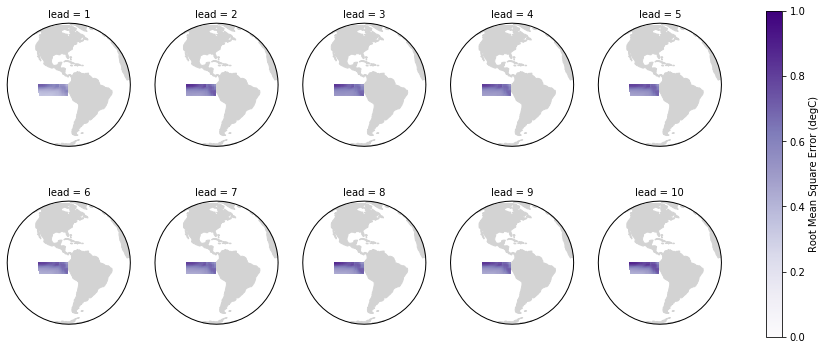

In [10]:
p = rmse.SST.plot.pcolormesh(x='TLONG', y='TLAT', 
                                       transform=ccrs.PlateCarree(), col='lead',
                                       col_wrap=5, vmin=0, vmax=1,
                                       subplot_kws={'projection': ccrs.Orthographic(-80, 0),},
                                       cmap='Purples', cbar_kwargs={'label': 'Root Mean Square Error (degC)'}
                                       )
for ax in p.axes.flat:
    ax.add_feature(cfeature.LAND, color='#d3d3d3', )
    ax.set_global()
    
plt.draw()